In [535]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import shap
from scipy.spatial import ConvexHull
set_config(transform_output="pandas")
import matplotlib.pyplot as plt
import contextlib 
import joblib
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import matplotlib.colors as mcolors
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import PolynomialFeatures
from sklearn import set_config
import os
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, SparkTrials
from scipy.stats import truncnorm
from scipy.stats import skewnorm
from scipy.optimize import minimize_scalar
from scipy.stats import skewnorm
from simulation import Simulation
from hyperopt.fmin import generate_trials_to_calculate
import random
import os
import logging
import tracemalloc
import psutil
mycol = ["red", "darkorange", "yellow", "limegreen", "dodgerblue", "deeppurple", "darkpink"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["dodgerblue", "limegreen"])

In [573]:
import pandas as pd

trials = pd.read_pickle('BEL_trials_14_Optimising_with_initial_probing_lumenvolcost_fccstart_pos.pkl')

def get_trials_dataframe(trials):
    data = []
    for trial in trials:
        row = trial['misc']['vals']
        row['loss'] = trial['result']['loss']
        data.append(row)
    
    return pd.DataFrame(data)

df = get_trials_dataframe(trials)
df = df.applymap(lambda x: x[0] if isinstance(x, list) else x).sort_values('loss', ascending=True)

In [575]:
df

alpha        beta  A_eq_star_scaling      P_star      loss
40337   0.807022  219.182598           0.000323    0.982330 -0.850540
26545   0.286845   46.472344           0.505001    0.802667 -0.845540
48643   0.116829  251.365094           0.595176    0.384140 -0.832253
9668    0.778716  160.810818           0.045597    1.072859 -0.831600
4010    0.009497    0.649101           0.464785  853.246534 -0.827468
...          ...         ...                ...         ...       ...
44276  18.343959  128.514527           0.411840   17.716282 -0.000000
44275  47.854162  185.020800           0.467057   61.255449 -0.000000
44274  32.482467  201.272379           0.017886   18.526186 -0.000000
16210  17.738629  169.330254           0.000460   19.714874 -0.000000
47022  18.238884  284.579695           0.535789   47.171975 -0.000000

[66634 rows x 5 columns]

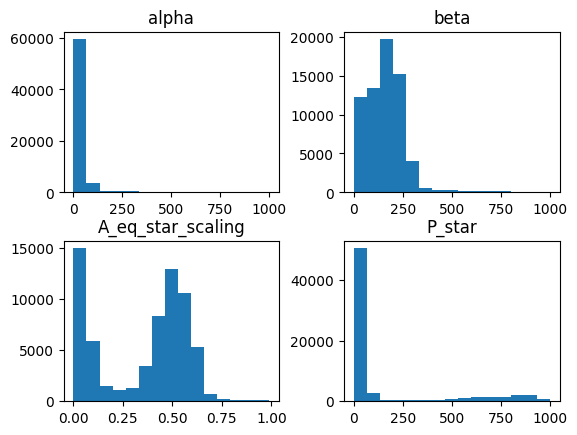

In [564]:
df.drop('loss', axis=1).hist(bins=15, grid=False)
fig = plt.gcf()
plt.savefig("parameter_optimisation_histograms.png")
plt.savefig("parameter_optimisation_histograms.pdf")

In [578]:
df[df["loss"]<-0.75].shape

(246, 5)

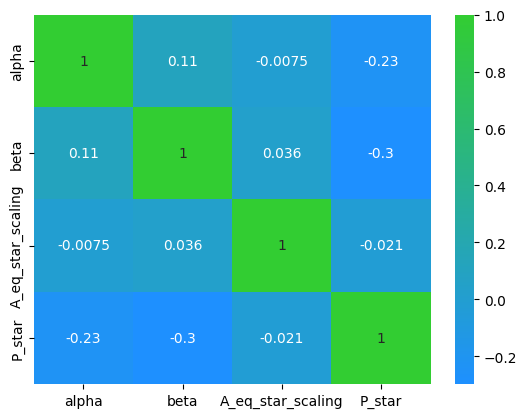

In [579]:
sns.heatmap(df[df["loss"]<-0.75].drop("loss", axis=1).corr(), annot=True, cmap=cmap)
fig = plt.gcf()
plt.savefig("parameter_optimisation_correlation.pdf")

In [451]:
def scaled_gaussian(x, mu, sigma):
    max_val = 1 / (sigma * np.sqrt(2 * np.pi))
    pdf_val = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    y = pdf_val / max_val
    return y

class ScaledSkewNormal:

    def __init__(self, a, mu, sigma):
        neg_pdf = lambda x: -skewnorm.pdf(x, a, mu, sigma)
        self.result = minimize_scalar(neg_pdf, bounds=(mu - 3*sigma, mu + 3*sigma), method='bounded')
        self.pdf_max_value = skewnorm.pdf(self.result.x, a, mu, sigma)
        self.a = a
        self.mu = mu
        self.sigma = sigma

    def get_value(self, x):
        pdf_val = skewnorm.pdf(x, self.a, self.mu, self.sigma)
        return pdf_val / self.pdf_max_value

def lumen_vol_dist(x):
    if 0 <= x <= 0.5:
        return 1
    elif 0.5 < x <= 1:
        return -2 * x + 2
    else:
        return 1e-30

def time_dist(x):
    return (x / 10) + 1e-30

def lumen_com_dist(x):
    if np.isnan(x):
        return 1e-30
    else:
        return 1 / np.exp(0.5*x)

def derive_target(
    mean_separation: float,
    #lumen_com: float,
    sphericity: float,
    n_cells: float,
    lumen_vol: float,
    hull_vol: float,
    max_time: float
) -> float:
    """
    Derive the value to be maximised from the results of the simulation.
    
    Inputs:
        results: The results of the simulation.
    
    Returns:
        The value to be maximised.
    """

    skew_normal_n_cells = ScaledSkewNormal(5, -80, 500)
    skew_normal_sphericity = ScaledSkewNormal(-5, 1.05, 0.3)
    
    mean_separation_optimisation_value = scaled_gaussian(mean_separation, mu=-0.2, sigma=0.3)
    sphericity_optimisation_value = skew_normal_sphericity.get_value(sphericity)
    n_cells_optimisation_value = skew_normal_n_cells.get_value(n_cells)
    lumen_vol_optimisation_value = lumen_vol_dist(lumen_vol/hull_vol)
    time_optimisation_value = time_dist(max_time)

    target_value = (
        mean_separation_optimisation_value *
        sphericity_optimisation_value *
        n_cells_optimisation_value *
        lumen_vol_optimisation_value *
        time_optimisation_value
    )

    return target_value

In [470]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [471]:
def extract_files(folder, substring):
    files = [os.path.join(folder, x) for x in os.listdir(folder)]
    files = [x for x in files if substring.lower() in x.lower()]
    return files

folders_containing_outputs = [f"F:\\Bel_Simulation\\outputs_{x}" for x in range(1, 7)]
run_files = sum([extract_files(x, 'run') for x in folders_containing_outputs], [])
ages_files = sum([extract_files(x, 'ages') for x in folders_containing_outputs], [])
positions_files = sum([extract_files(x, 'positions') for x in folders_containing_outputs], [])


def extract_files(folder, substring):
    files = [os.path.join(folder, x) for x in os.listdir(folder)]
    files = [x for x in files if substring.lower() in x.lower()]
    return files

def create_dataframe(files, column_name):
    df = pd.DataFrame(files, columns=[column_name])
    df['folder'] = df[column_name].apply(lambda x: x.split('\\')[-2])
    df['run'] = df[column_name].apply(lambda x: x.split('\\')[-1].split('_')[-1].split('.')[0]).apply(lambda x: [x for x in x if x.isdigit()]).apply(lambda x: ''.join(x)).astype(int)
    return df

root = "f:\\Bel_Simulation"

#folders = ["\\Optimisation Output with Initial Parameter Space Probing 3", "\\Optimisation Output with Initial Parameter Space Probing GOOD RANGE ONLY", "\\Outputs_no_optimisation_good_range_70init"]
folders = ["\\Outputs_no_optimisation_good_range_70init_0p1vol_Pstar_alphafixed_1in20_std"]
# folders_containing_outputs = [f"F:\\Bel_Simulation\\outputs_{x}" for x in range(1, 7)]
folders_containing_outputs =[root + x for x in folders]
run_files = sum([extract_files(x, 'run') for x in folders_containing_outputs], [])
ages_files = sum([extract_files(x, 'ages') for x in folders_containing_outputs], [])
positions_files = sum([extract_files(x, 'positions') for x in folders_containing_outputs], [])

run_files = create_dataframe(run_files, 'run_files')
ages_files = create_dataframe(ages_files, 'ages_files')
positions_files = create_dataframe(positions_files, 'positions_files')

run_files = run_files.merge(ages_files, on=['folder', 'run'], how='inner')
run_files = run_files.merge(positions_files, on=['folder', 'run'], how='inner')
run_files.drop(columns=['folder', 'run'], inplace=True)

run_files_chunks = np.array_split(run_files, 48)

In [472]:
def find_params(run, ages, positions):
    try:
        final_params = pd.read_parquet(run).tail(1)
        return final_params
    except:
        return pd.DataFrame()

def get_params(data):
    params = []
    for index, row in data.iterrows():
        parameters = find_params(row['run_files'], row['ages_files'], row['positions_files'])
        parameters['folder'] = row['run_files'].split("\\")[2]
        params.append(parameters)
    return pd.concat(params)


In [473]:
with tqdm_joblib(tqdm(desc="My Simulation", total=len(run_files_chunks))) as progress_bar:
    final_props = Parallel(n_jobs=4)(delayed(get_params)(chunk) for chunk in run_files_chunks)

My Simulation:   0%|          | 0/48 [00:00<?, ?it/s]

In [474]:
# output = pd.concat(final_props)
# output.to_parquet("final_props_200624_12pm.parquet")
output = pd.concat(final_props)
output.to_parquet("final_props_210624_4pm_only70init_0p1vol_pstaralphafixed_1in20ltstd.parquet")

In [482]:
#output1 = pd.read_parquet("final_props_200624_12pm.parquet")
output2 = pd.read_parquet("final_props_200624_4pm_only70init_0p1vol.parquet")
output3 = pd.read_parquet("final_props_200624_4pm_only70init_0p1vol.parquet")
output4 = pd.read_parquet("final_props_200624_4pm_0p1vol_belpc_varypstar_varyalpha.parquet")
output5 = pd.read_parquet("final_props_210624_4pm_only70init_0p1vol_pstaralphafixed_1in20ltstd.parquet")
output6 = pd.read_parquet("final_props_210624_12pm_0p1vol_belpc_pstar_alpha_fixed_ltstd1in20.parquet")
output7 = pd.read_parquet("final_props_220624_4pm_only70init_0p1vol_pstaralphafixed_1in20ltstd.parquet")
output8 = pd.read_parquet("extra_final_props_210624_7pm_0p1vol_belpc_pstar_alpha_fixed_ltstd1in20.parquet")
output9 = pd.read_parquet("extra_final_props_220624_7pm_0p1vol_belpc_pstar_alpha_fixed_ltstd1in20.parquet")
output10 = pd.read_parquet("extra_final_props_220624_1pm_0p1vol_belpc_pstar_alpha_fixed_ltstd1in20.parquet")
output11 = pd.read_parquet("extra_final_props_230624_1pm_0p1vol_belpc_pstar_alpha_fixed_ltstd1in20.parquet")
total_outputs = pd.concat([ output2, output3, output4, output5, output6, output7, output8, output9, output10, output11])
total_outputs['target'] = total_outputs.apply(lambda row: derive_target(row['mean_separation'], row['sphericity'], row['final_N_bodies'], 
                              row['lumen_volume'], row['hull_volume'], row['t']), axis=1)

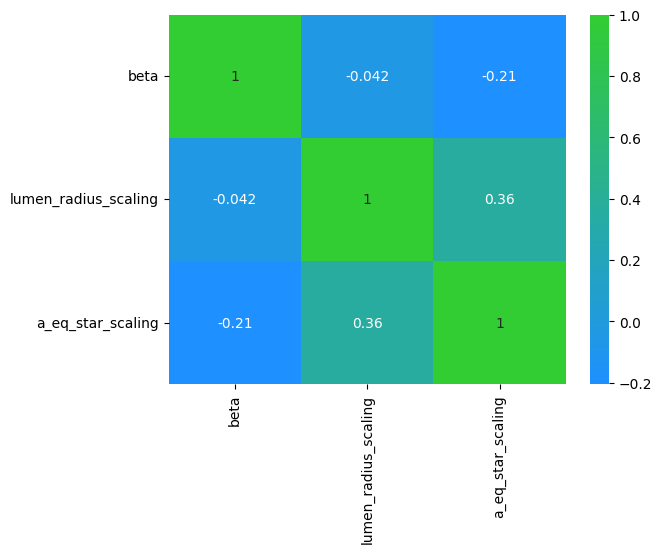

In [569]:
sns.heatmap(good_runs_good_cost[["beta", "lumen_radius_scaling", "a_eq_star_scaling" ]].corr(), annot=True, cmap=cmap)
fig = plt.gcf()
plt.savefig("parameter_optimisation_correlation.pdf")

In [476]:
print(total_outputs.shape)
good_runs = total_outputs[(total_outputs["t"]==10)]
print(good_runs.shape)
good_runs_good_cost = good_runs[good_runs["target"]>0.55]
print(good_runs_good_cost.shape)
# output = output[output.Cluster_Vol <= 5000]

(11597, 19)
(3367, 19)


In [477]:
# total_outputs.to_parquet("all_runs_2306.parquet")

In [65]:
good_runs_good_cost["lumen/hull_vol"] = good_runs_good_cost["lumen_volume"]/good_runs_good_cost["hull_volume"] *100 

In [82]:
good_runs_good_cost[good_runs_good_cost["target"]>0.84][['alpha', 'beta', 'p_star', 'a_eq_star_scaling', 'lumen_radius_scaling', "lumen_volume_scaling"]]

alpha        beta    p_star  a_eq_star_scaling  \
71473  0.286845   46.472344  0.802667           0.505001   
68006  0.807022  219.182598  0.982330           0.000323   

       lumen_radius_scaling  lumen_volume_scaling  
71473              1.314885              0.067060  
68006              0.915140              0.015745

In [93]:
good_runs_good_cost["folder"].unique()

array(['Optimisation Output with Initial Parameter Space Probing 3',
       'Optimisation Output with Initial Parameter Space Probing GOOD RANGE ONLY',
       'Outputs_no_optimisation_good_range_70init'], dtype=object)

In [94]:
parameters = good_runs_good_cost[(good_runs_good_cost["final_N_bodies"] < 250) & (good_runs_good_cost["folder"]!='Optimisation Output with Initial Parameter Space Probing 3')][['alpha', 'beta', 'p_star', 'a_eq_star_scaling', 'lumen_radius_scaling', "lumen_volume_scaling"]]
parameters.describe()

alpha        beta      p_star  a_eq_star_scaling  \
count  277.000000  277.000000  277.000000         277.000000   
mean     0.349051  154.271319    1.001105           0.248448   
std      0.225259  100.148417    0.433279           0.167719   
min      0.000078    0.020708    0.016257           0.000111   
25%      0.172398   71.120333    0.648470           0.100661   
50%      0.321910  143.417416    0.908633           0.226238   
75%      0.476326  222.005309    1.306151           0.372888   
max      0.986085  394.290592    1.987165           0.617824   

       lumen_radius_scaling  lumen_volume_scaling  
count            277.000000            277.000000  
mean               1.032137              0.053275  
std                0.281053              0.025515  
min                0.505299              0.010448  
25%                0.805971              0.031444  
50%                1.043841              0.050000  
75%                1.232760              0.073247  
max                1.777260              0.099991

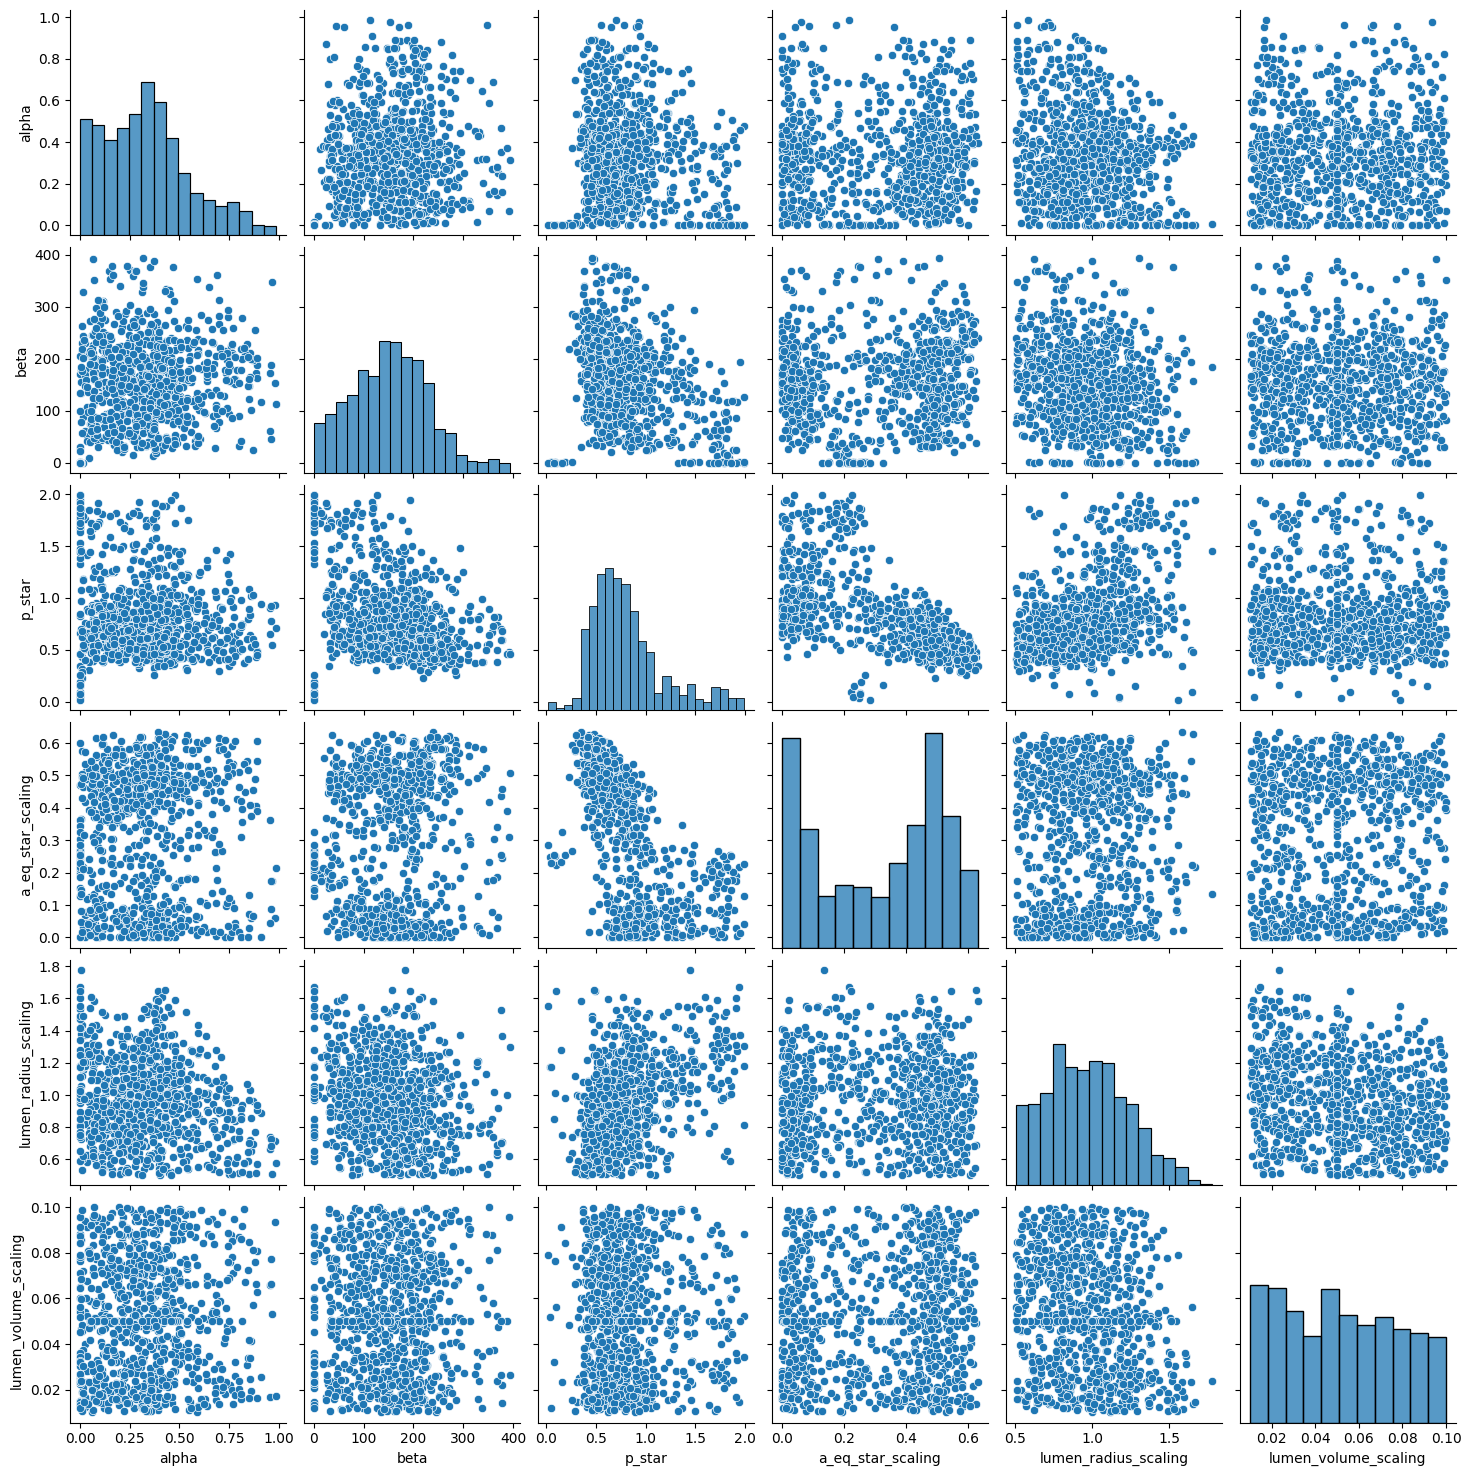

In [76]:
sns.pairplot(parameters)
plt.savefig("successful_parameter_analysis.pdf", transparent=True, bbox_inches='tight')

<Axes: xlabel='lumen/hull_vol', ylabel='lumen_volume_scaling'>

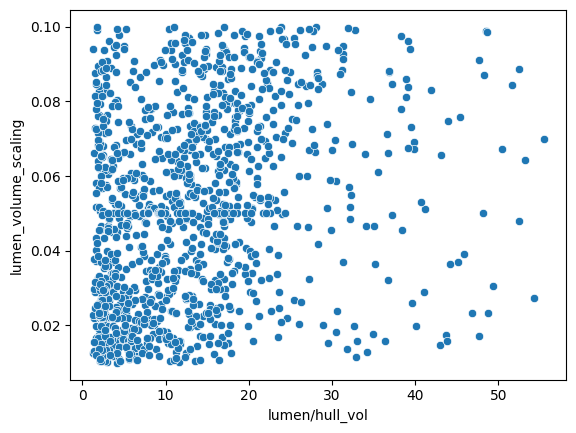

In [47]:
sns.scatterplot(data = good_runs_good_cost, x="lumen/hull_vol", y="lumen_volume_scaling")

In [54]:
#sns.scatterplot(data=output[(output.end_reason.isna())], x='lumen_radius_scaling', y='Cluster_Vol', palette="hsv", hue="alpha", legend="full")

In [52]:
output.groupby('end_reason', dropna=False).size()

end_reason
unknown_uncaught    3583
unphysical_area     8154
unphysical_hull     7467
NaN                 1012
dtype: int64

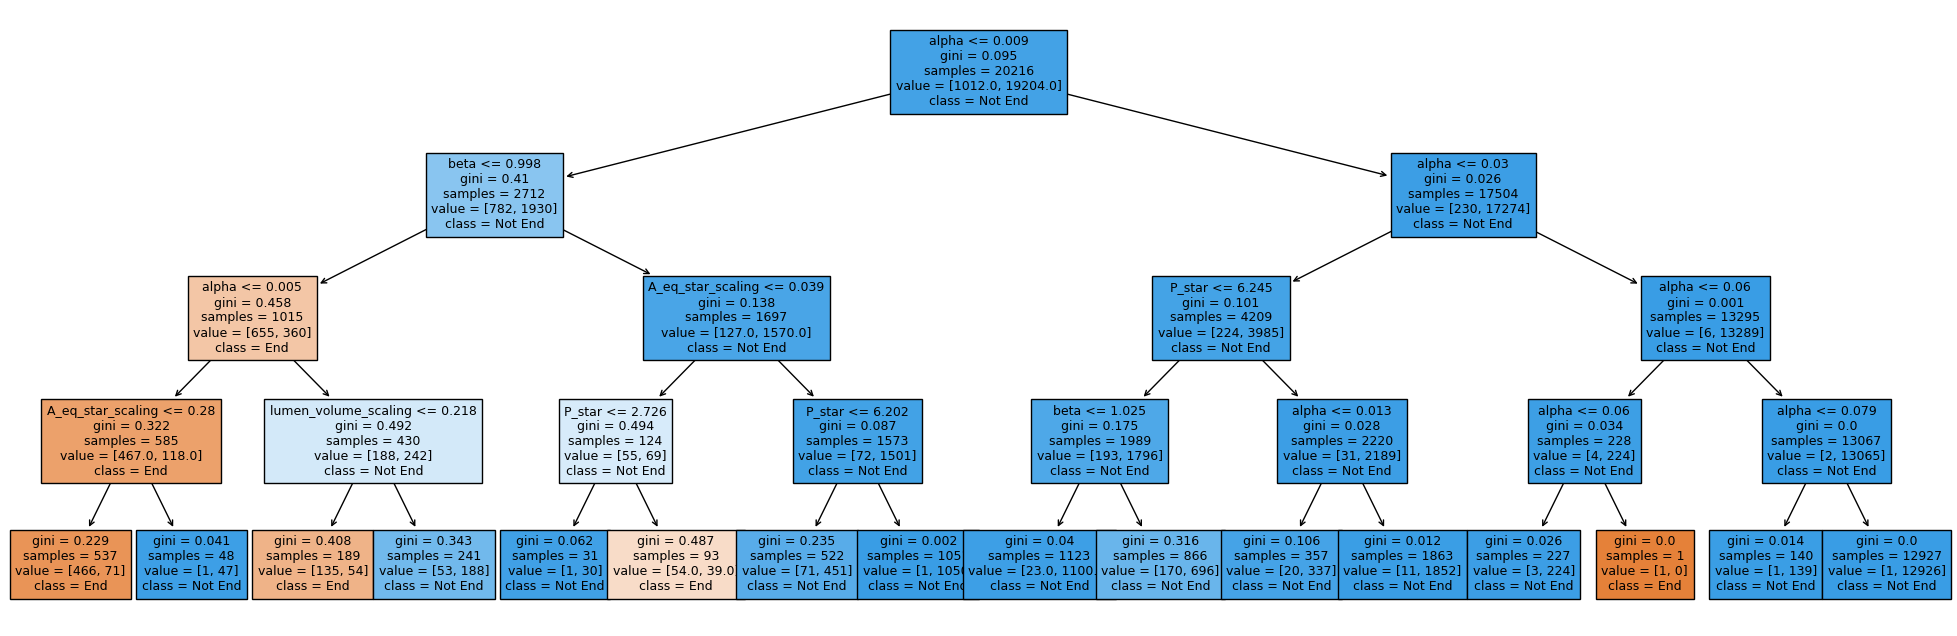

In [53]:
clf = DecisionTreeClassifier(max_depth=4)
X, y = output[['alpha', 'beta', 'P_star', 'A_eq_star_scaling', 'lumen_volume_scaling', 'lumen_radius_scaling']], output.end_reason
y.fillna(1, inplace=True)
y = y.apply(lambda x: 1 if x != 1 else 0)
clf.fit(X, y)
fig, ax = plt.subplots(figsize=(25, 8))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['End', 'Not End'], ax=ax, fontsize=9);

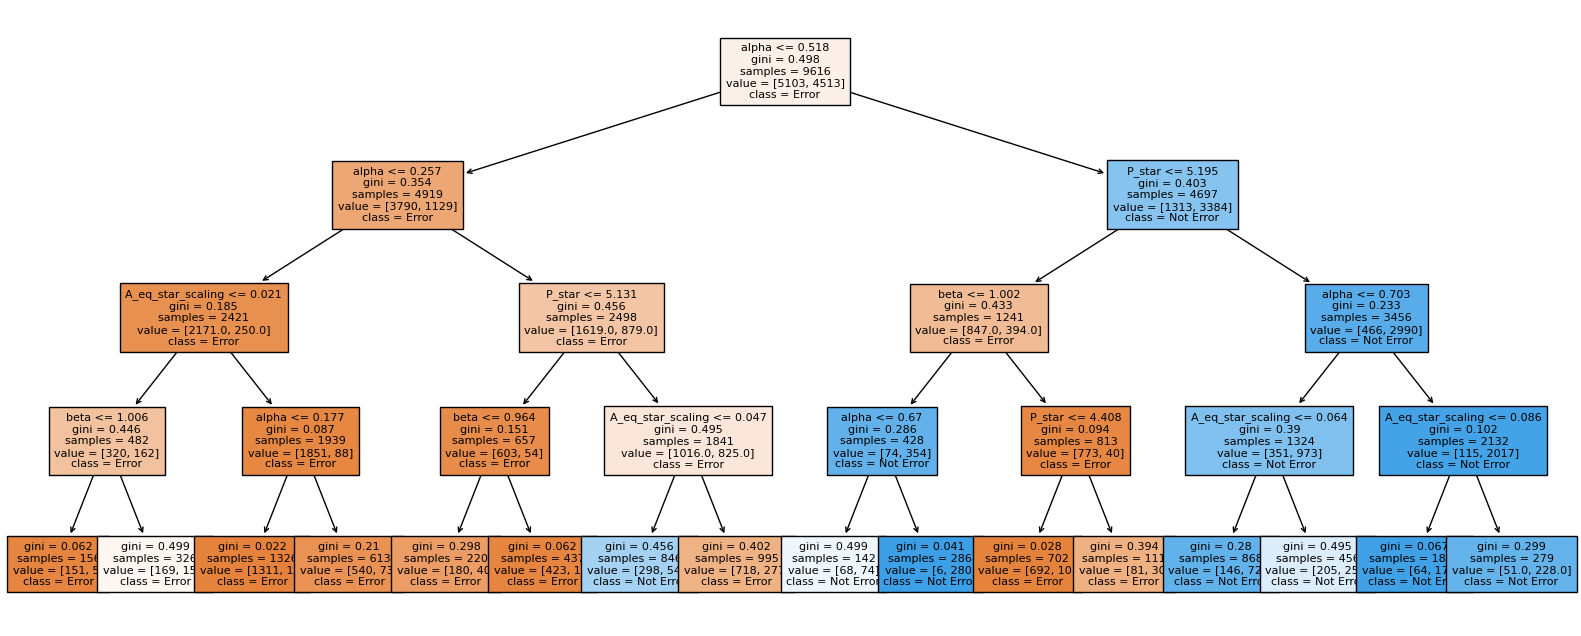

In [49]:
clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=10)
X, y = output[['alpha', 'beta', 'P_star', 'A_eq_star_scaling', 'lumen_volume_scaling', 'lumen_radius_scaling']], output.end_reason
y = y.apply(lambda x: 1 if x == 'unknown_uncaught' else 0)
clf.fit(X, y)
fig, ax = plt.subplots(figsize=(20, 8))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Error', 'Not Error'], ax=ax, fontsize=8, );

In [34]:
output[(output.Cluster_Vol <= 1000) & (output.end_reason.isna())].sort_values('Cluster_Vol')

t  Cluster_Vol     Areas  Preferred_area  Lumen_volume  Run_No  \
120441  20.0     0.030606  0.397497        0.051516     65.005768    2420   
120632  20.0     0.031383  1.721715        0.111487      9.180335     704   
120546  20.0     0.040177  0.847065        0.037102     68.721775     697   
120368  20.0     0.082998  0.375333        0.052233      8.970585    3263   
120777  20.0     0.124724  2.127938        0.316666     69.377138    1773   
...      ...          ...       ...             ...           ...     ...   
121435  20.0   958.257833  6.665833        0.838423      9.686388    3177   
121396  20.0   963.342801  5.723786        0.170942     74.615412    1030   
121330  20.0   974.074837  5.626653        0.245239      7.122214     683   
121534  20.0   997.219811  5.341784        0.502077      5.869294     796   
121488  20.0   998.476640  6.013393        0.131460     16.543241     107   

        r_min      beta     alpha  A_eq_star_scaling     P_star  \
120441      1  0.539619  0.011338           0.129602  11.349254   
120632      1  0.179099  0.009631           0.064754   1.210129   
120546      1  0.101782  0.012052           0.043801  13.058065   
120368      1  0.127971  0.023843           0.139163   7.142896   
120777      1  0.257299  0.008399           0.148814   4.124730   
...       ...       ...       ...                ...        ...   
121435      1  2.322160  0.008153           0.125779   3.925447   
121396      1  1.999793  0.029757           0.029865   3.715010   
121330      1  1.028622  0.010421           0.043585   3.595416   
121534      1  2.359432  0.015553           0.093991   3.230138   
121488      1  2.951990  0.002255           0.021861   3.891203   

        mean_lifetime  lumen_volume_scaling  lumen_radius_scaling end_reason  
120441              5              0.353700              0.553665       None  
120632              5              0.013890              0.777078       None  
120546              5              0.297672              0.542752       None  
120368              5              0.013012              0.566103       None  
120777              5              0.216875              0.565978       None  
...               ...                   ...                   ...        ...  
121435              5              0.027927              0.770117       None  
121396              5              0.389499              0.710679       None  
121330              5              0.269845              0.725879       None  
121534              5              0.023766              0.521786       None  
121488              5              0.409101              0.551954       None  

[296 rows x 15 columns]

In [64]:
output['density'] = output.N_cells / output.Cluster_Vol

In [65]:
output[(output.end_reason == 1) & (output.density > 10) & (output.density < 14)]

t  Cluster_Vol     Areas  Preferred_area  Lumen_volume  Run_No  \
120401  20.0     0.510765  1.308972        0.048081     16.167708    2243   
120401  20.0     0.607343  1.404424        0.205069     10.766244    2694   
120803  20.0     0.961484  0.824243        0.086088     26.015852    1250   
120553  20.0     0.475659  1.425025        0.189864     33.452812     139   
121027  20.0     1.664563  0.414604        0.009981     19.846215    2112   
120625  20.0     0.876628  0.823815        0.050483     10.377376     341   
121330  20.0     8.291584  0.343636        0.025547      8.317000     542   
120401  20.0     0.373259  4.149397        0.604380     39.386998     651   
121225  20.0     2.517078  0.456452        0.032829      9.509236     882   
120533  20.0     0.426934  3.786372        0.755075     19.338517     939   

        r_min      beta     alpha  A_eq_star_scaling     P_star  \
120401      1  0.844358  0.016371           0.036732  16.133549   
120401      1  0.692323  0.015135           0.146016   1.541219   
120803      1  0.620650  0.009976           0.104445   0.704221   
120553      1  0.630130  0.008957           0.133235   6.715131   
121027      1  0.859293  0.009486           0.024073   2.484994   
120625      1  0.988469  0.009256           0.061280   3.970743   
121330      1  0.569069  0.006284           0.074343   4.797368   
120401      1  0.766118  0.014497           0.145655   4.555551   
121225      1  0.949512  0.008615           0.071922   2.471120   
120533      1  0.500876  0.008587           0.199419   4.149329   

        mean_lifetime  lumen_volume_scaling  lumen_radius_scaling end_reason  \
120401              5              0.063242              0.735305          1   
120401              5              0.037350              0.958391          1   
120803              5              0.083599              0.622220          1   
120553              5              0.122515              0.759656          1   
121027              5              0.042022              0.568206          1   
120625              5              0.010024              0.733438          1   
121330              5              0.003798              0.551154          1   
120401              5              0.188951              0.700371          1   
121225              5              0.014707              0.608801          1   
120533              5              0.072986              0.824866          1   

        N_cells    Volume    density  
120401        6  0.510765  11.747088  
120401        7  0.607343  11.525605  
120803       13  0.961484  13.520765  
120553        6  0.475659  12.614087  
121027       19  1.664563  11.414409  
120625       10  0.876628  11.407343  
121330       91  8.291584  10.974984  
120401        5  0.373259  13.395512  
121225       33  2.517078  13.110439  
120533        5  0.426934  11.711415

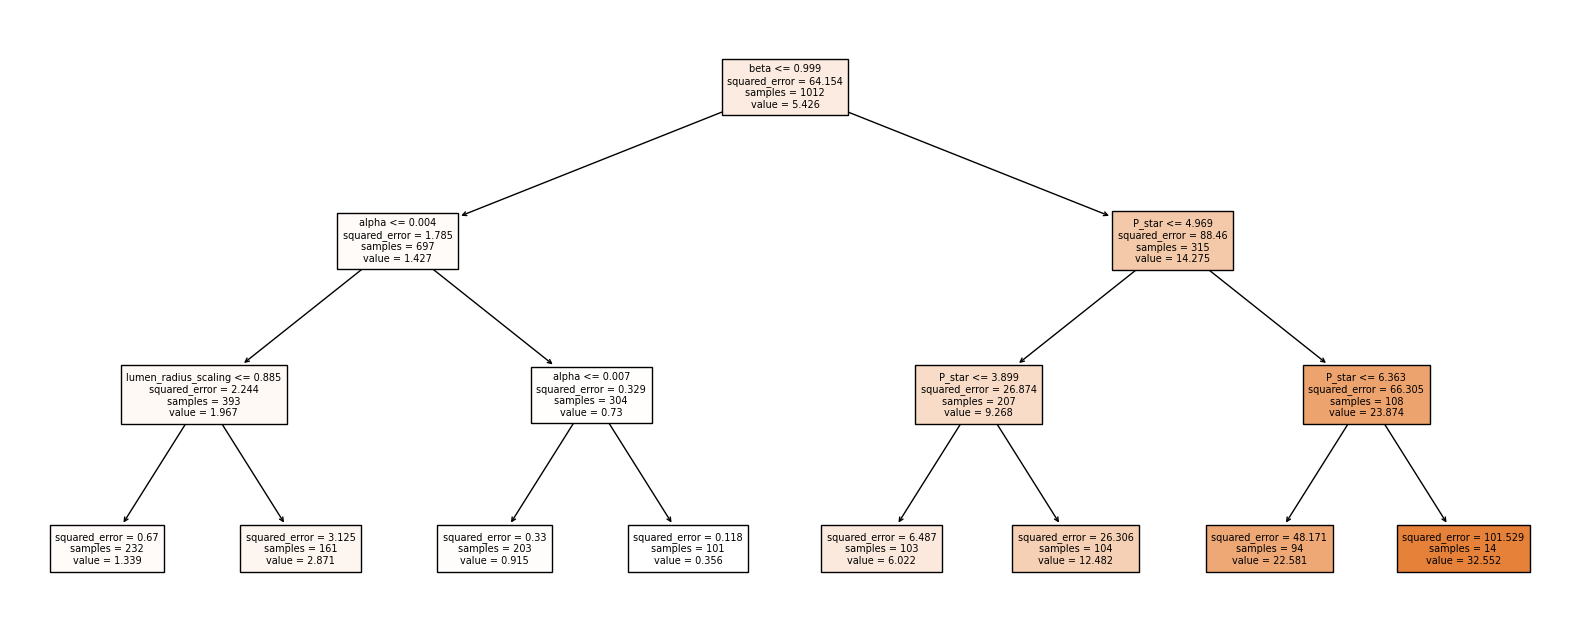

In [63]:
clf = DecisionTreeRegressor(max_depth=3, min_samples_leaf=10)
X, y = output[output.end_reason == 1][['alpha', 'beta', 'P_star', 'A_eq_star_scaling', 'lumen_volume_scaling', 'lumen_radius_scaling']], output[output.end_reason == 1].Cluster_Vol / output[output.end_reason == 1].N_cells
clf.fit(X, y)
fig, ax = plt.subplots(figsize=(20, 8))
plot_tree(clf, filled=True, feature_names=X.columns, ax=ax, fontsize=7, );

In [30]:
data["Areas"] = data["Areas"]/ data["Preferred_area"] # area now represents the proprtional difference from the equilibrium

In [609]:
def plot_shap_custom(output_param, X, y, check_additivity = False):
    # Train the model
    model = RandomForestRegressor(max_depth=6, n_jobs=-1, n_estimators=500, max_features=0.33)
    model.fit(X, y[output_param])
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X, check_additivity = check_additivity)
    feature_names = X.columns
    shap_df = pd.DataFrame(shap_values, columns=feature_names)
    feature_df = pd.DataFrame(X, columns=feature_names)
    shap_df['instance'] = range(len(shap_df))
    shap_values = explainer.shap_values(X, check_additivity=check_additivity)
    shap.summary_plot(shap_values, X, plot_size=(7,5), show=False, max_display=15, 
                      plot_type='dot', feature_names=X.columns, cmap=cmap)
    plt.title("{} Important Params".format(output_param.replace("_", " ")))
    plt.savefig("{} Important Params.pdf".format(output_param.replace("_", " ")), transparent=True, bbox_inches='tight')
    plt.savefig("{} Important Params.png".format(output_param.replace("_", " ")), transparent=True, bbox_inches='tight')
    ax= plt.gca()
    plt.show()

#############Individual Params
    fig, axs = plt.subplots(nrows=len(feature_names), figsize=(4, 3*len(feature_names)))
    print("all feature names", feature_names)
    for i, feature in enumerate(feature_names):
        axs[i].scatter(feature_df[feature], shap_df[feature], alpha=0.5, color="dodgerblue")
        axs[i].set_xlabel("{} value".format(nice_string_format(feature)))
        axs[i].set_ylabel("SHAP value (impact on model output)")
        #axs[i].set_title("{}'s impact on {}".format(nice_string_format(feature), nice_string_format(output_param)))
    plt.tight_layout()
    plt.savefig("{} Individual Important Params.pdf".format(output_param.replace("_", " ")), transparent=True, bbox_inches='tight')
    plt.savefig("{} Individual Important Params.png".format(output_param.replace("_", " ")), transparent=True, bbox_inches='tight')
    plt.show()

def nice_string_format(str):
    return  str.replace("beta", r"$\beta$").replace("A_eq_star_scaling",  r"$A'^\star_{scaling}$").replace("N_cells", r"$N_{cells}$").replace("lumen_radius_scaling", r"$r_l$").replace("lumen_volume_scaling", r"$V_l$")
    

# No Interactions

In [610]:
successful_output = total_outputs[(total_outputs["t"]==10)&(total_outputs["cluster_vol"]<1000)& (total_outputs["p_star"]==1) & (total_outputs["alpha"]==0.3) ]
successful_output = successful_output[successful_output["target"]>0.65]
print(successful_output.shape)

(2883, 19)


In [611]:
successful_output = successful_output.drop_duplicates(keep=False)

In [612]:
X, y = successful_output[["beta", "a_eq_star_scaling","lumen_radius_scaling"]], successful_output[['cluster_vol', "lumen_volume", 'final_N_bodies', "sphericity", "t", "target"]].rename(columns={'t': 't_max'})

In [602]:
for parameter in ["cluster_vol", "target", "sphericity", "final_N_bodies"]:
    model = RandomForestRegressor(max_depth=6, n_jobs=-1, n_estimators=500, max_features=0.33)
    model.fit(X, y[parameter]);
    data = pd.DataFrame(zip(X.columns, model.feature_importances_), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False).sort_values('Importance', ascending=False)[:10]
    data.to_csv("{}_feature_importance.csv".format(parameter))

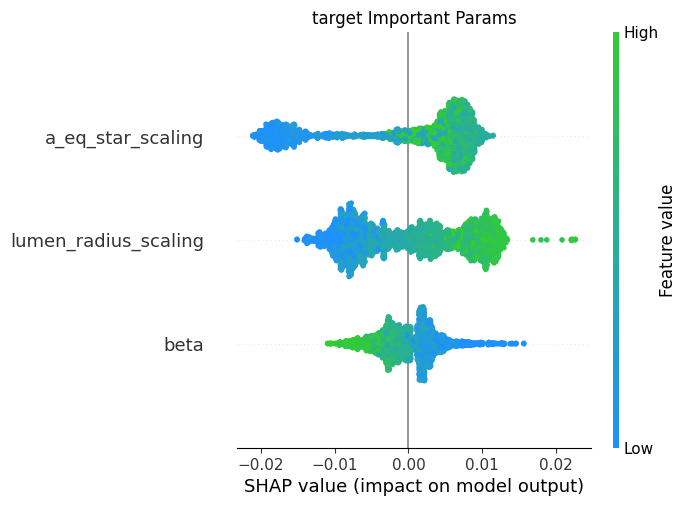

all feature names Index(['beta', 'a_eq_star_scaling', 'lumen_radius_scaling'], dtype='object')


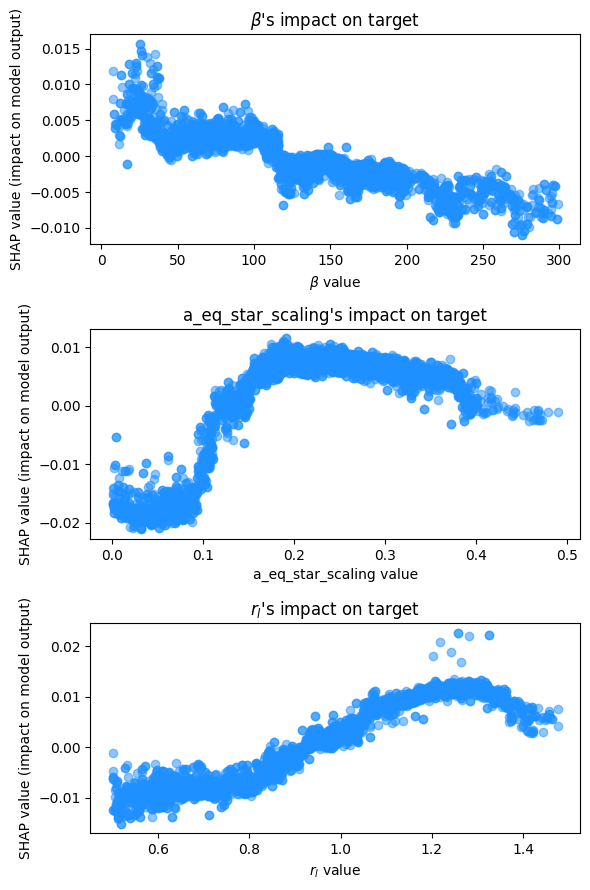

In [519]:
plot_shap_custom("target", X, y)

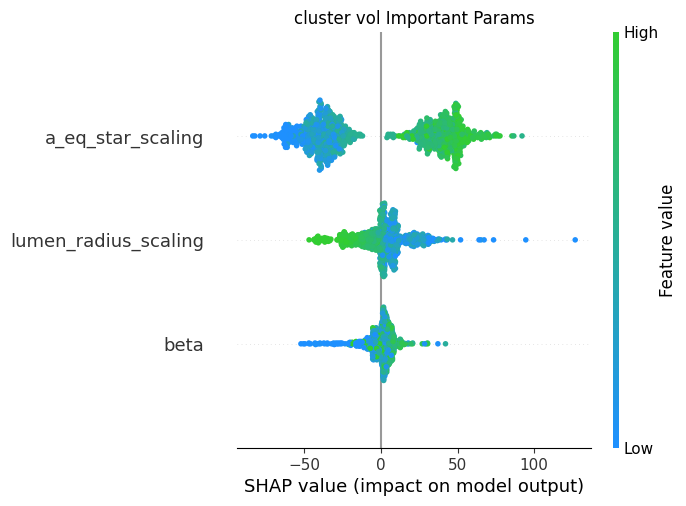

all feature names Index(['beta', 'a_eq_star_scaling', 'lumen_radius_scaling'], dtype='object')


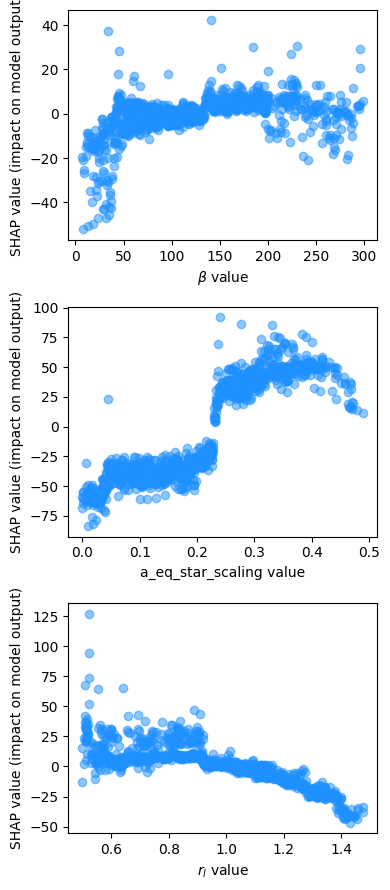

In [613]:
plot_shap_custom("cluster_vol", X, y)

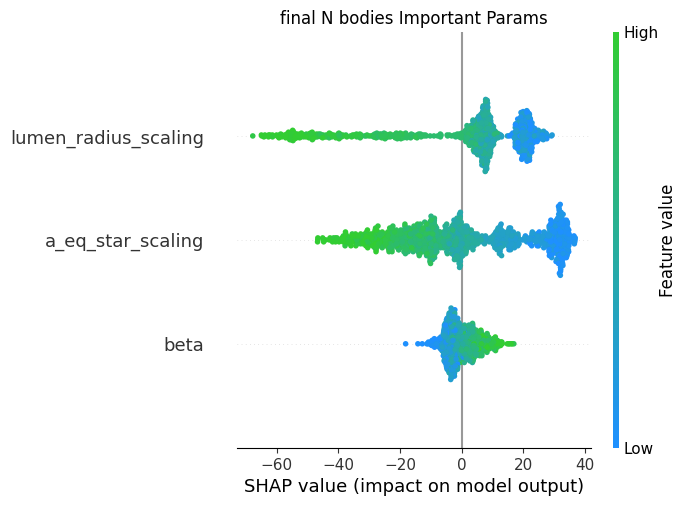

all feature names Index(['beta', 'a_eq_star_scaling', 'lumen_radius_scaling'], dtype='object')


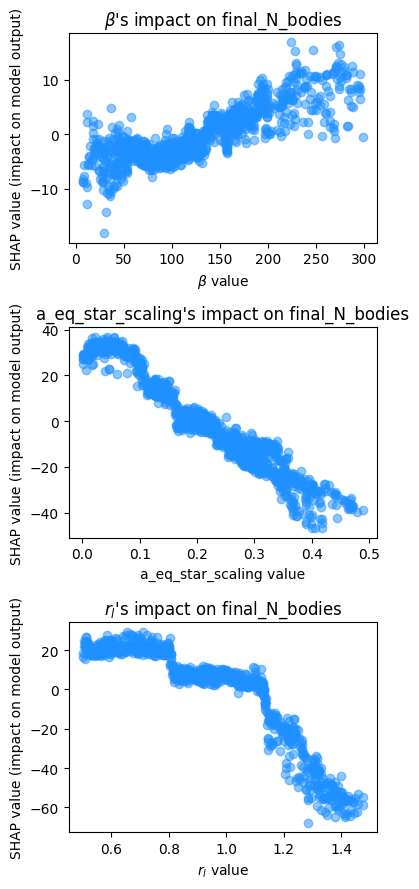

In [604]:
plot_shap_custom("final_N_bodies", X, y)

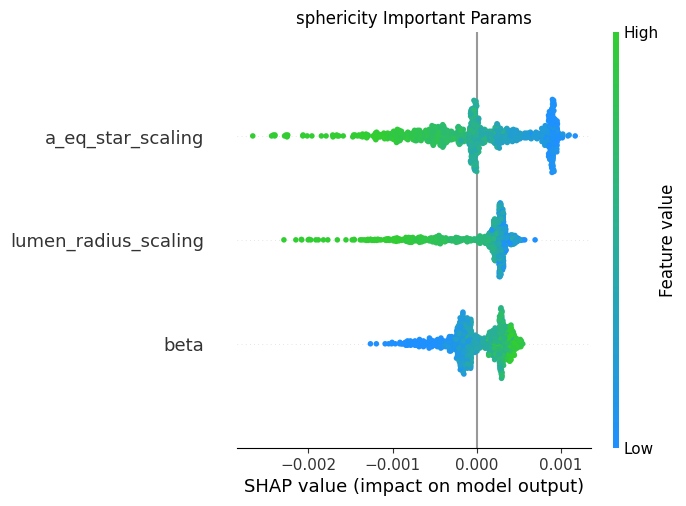

all feature names Index(['beta', 'a_eq_star_scaling', 'lumen_radius_scaling'], dtype='object')


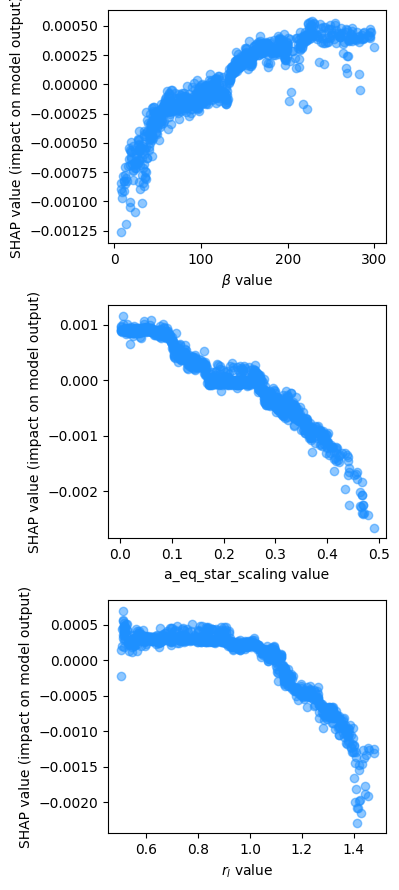

In [607]:
plot_shap_custom("sphericity", X, y)

# Including Interactions

In [614]:
X, y = successful_output[["beta", "a_eq_star_scaling","lumen_radius_scaling"]], successful_output[['cluster_vol', "lumen_volume", 'final_N_bodies', "sphericity", "t", "target"]].rename(columns={'t': 't_max'})
original_features = X.columns.tolist()
inverse_features = 1 / X
inverse_features.columns = ['1/{}'.format(x) for x in inverse_features.columns]
X = pd.concat([X, inverse_features], axis=1) # X = input paramaters, y = output results, axis = 1 = stick the columns on the end
for i, feature1 in enumerate(original_features):
    for feature2 in original_features[i+1:]:
        X[f'{feature1}*{feature2}'] = X[feature1] * X[feature2]
        X[f'{feature1}/{feature2}'] = X[feature1] / X[feature2]
print(X.columns)
model = RandomForestRegressor(max_depth=6, n_jobs=-1, n_estimators=500, max_features=0.33)
model.fit(X, y["t_max"]);
data = pd.DataFrame(zip(X.columns, model.feature_importances_), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False).sort_values('Importance', ascending=False)[:10]
data.to_csv("t_max_feature_importance_from_all_data_including_interactions.csv".format(parameter))
data

Index(['beta', 'a_eq_star_scaling', 'lumen_radius_scaling', '1/beta',
       '1/a_eq_star_scaling', '1/lumen_radius_scaling',
       'beta*a_eq_star_scaling', 'beta/a_eq_star_scaling',
       'beta*lumen_radius_scaling', 'beta/lumen_radius_scaling',
       'a_eq_star_scaling*lumen_radius_scaling',
       'a_eq_star_scaling/lumen_radius_scaling'],
      dtype='object')


Feature  Importance
0                       beta         0.0
1          a_eq_star_scaling         0.0
2       lumen_radius_scaling         0.0
3                     1/beta         0.0
4        1/a_eq_star_scaling         0.0
5     1/lumen_radius_scaling         0.0
6     beta*a_eq_star_scaling         0.0
7     beta/a_eq_star_scaling         0.0
8  beta*lumen_radius_scaling         0.0
9  beta/lumen_radius_scaling         0.0

In [615]:
X, y = successful_output[["beta", "a_eq_star_scaling","lumen_radius_scaling"]], successful_output[['cluster_vol', "lumen_volume", 'final_N_bodies', "sphericity", "t", "target"]].rename(columns={'t': 't_max'})
original_features = X.columns.tolist()
inverse_features = 1 / X
inverse_features.columns = ['1/{}'.format(x) for x in inverse_features.columns]
X = pd.concat([X, inverse_features], axis=1) # X = input paramaters, y = output results, axis = 1 = stick the columns on the end
for i, feature1 in enumerate(original_features):
    for feature2 in original_features[i+1:]:
        X[f'{feature1}*{feature2}'] = X[feature1] * X[feature2]
        X[f'{feature1}/{feature2}'] = X[feature1] / X[feature2]
print(X.columns)


Index(['beta', 'a_eq_star_scaling', 'lumen_radius_scaling', '1/beta',
       '1/a_eq_star_scaling', '1/lumen_radius_scaling',
       'beta*a_eq_star_scaling', 'beta/a_eq_star_scaling',
       'beta*lumen_radius_scaling', 'beta/lumen_radius_scaling',
       'a_eq_star_scaling*lumen_radius_scaling',
       'a_eq_star_scaling/lumen_radius_scaling'],
      dtype='object')


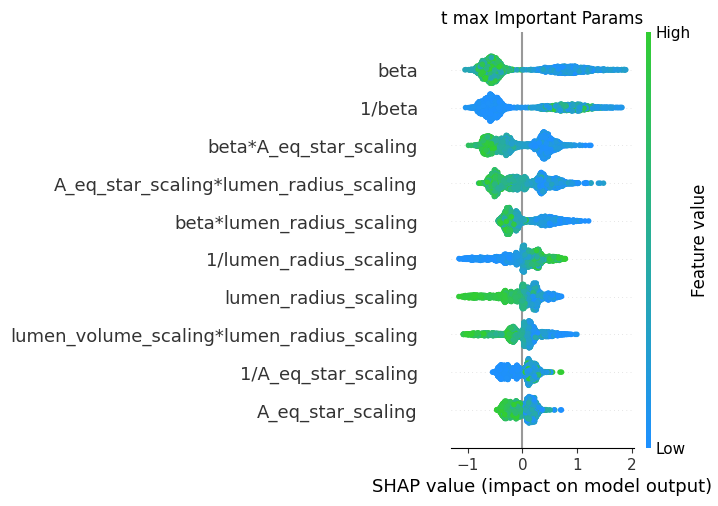

all feature names Index(['beta', 'A_eq_star_scaling', 'lumen_volume_scaling',
       'lumen_radius_scaling', '1/beta', '1/A_eq_star_scaling',
       '1/lumen_volume_scaling', '1/lumen_radius_scaling',
       'beta*A_eq_star_scaling', 'beta/A_eq_star_scaling',
       'beta*lumen_volume_scaling', 'beta/lumen_volume_scaling',
       'beta*lumen_radius_scaling', 'beta/lumen_radius_scaling',
       'A_eq_star_scaling*lumen_volume_scaling',
       'A_eq_star_scaling/lumen_volume_scaling',
       'A_eq_star_scaling*lumen_radius_scaling',
       'A_eq_star_scaling/lumen_radius_scaling',
       'lumen_volume_scaling*lumen_radius_scaling',
       'lumen_volume_scaling/lumen_radius_scaling'],
      dtype='object')


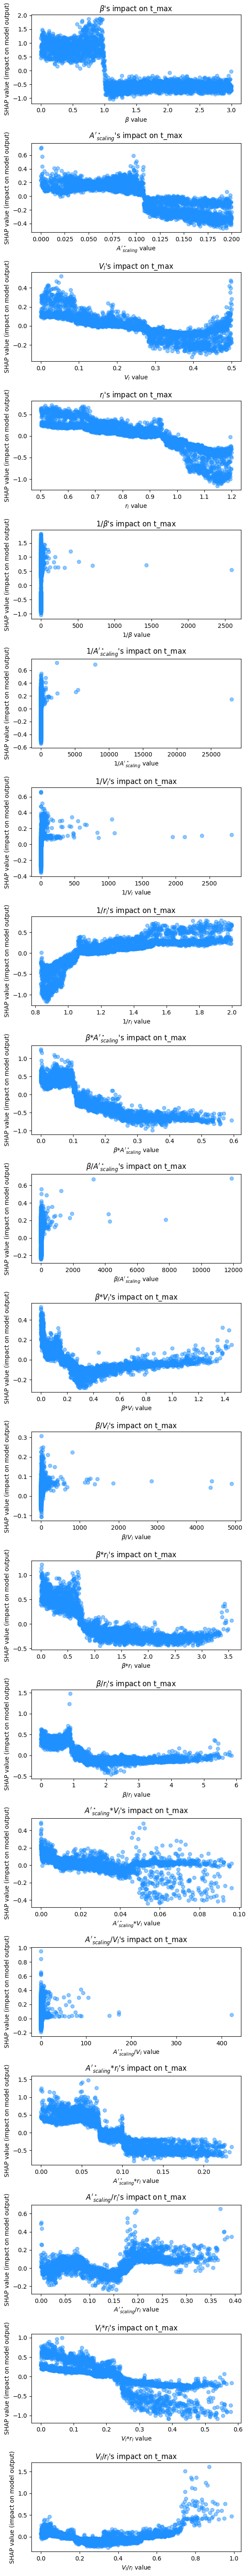

In [28]:
plot_shap_custom("t_max", X, y)

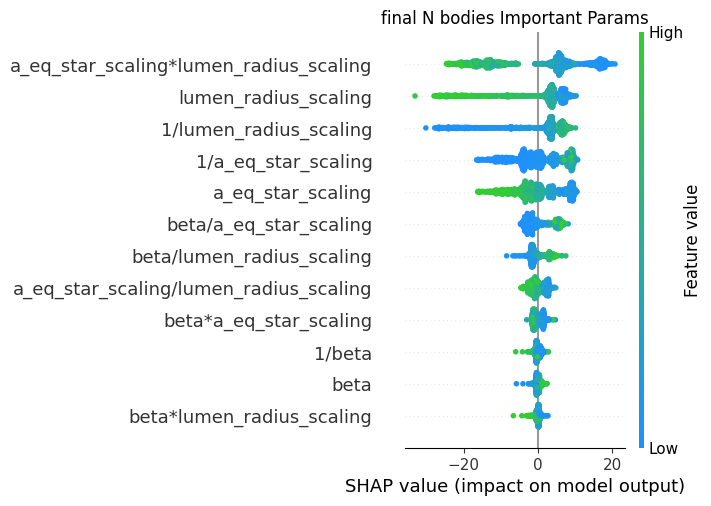

all feature names Index(['beta', 'a_eq_star_scaling', 'lumen_radius_scaling', '1/beta',
       '1/a_eq_star_scaling', '1/lumen_radius_scaling',
       'beta*a_eq_star_scaling', 'beta/a_eq_star_scaling',
       'beta*lumen_radius_scaling', 'beta/lumen_radius_scaling',
       'a_eq_star_scaling*lumen_radius_scaling',
       'a_eq_star_scaling/lumen_radius_scaling'],
      dtype='object')


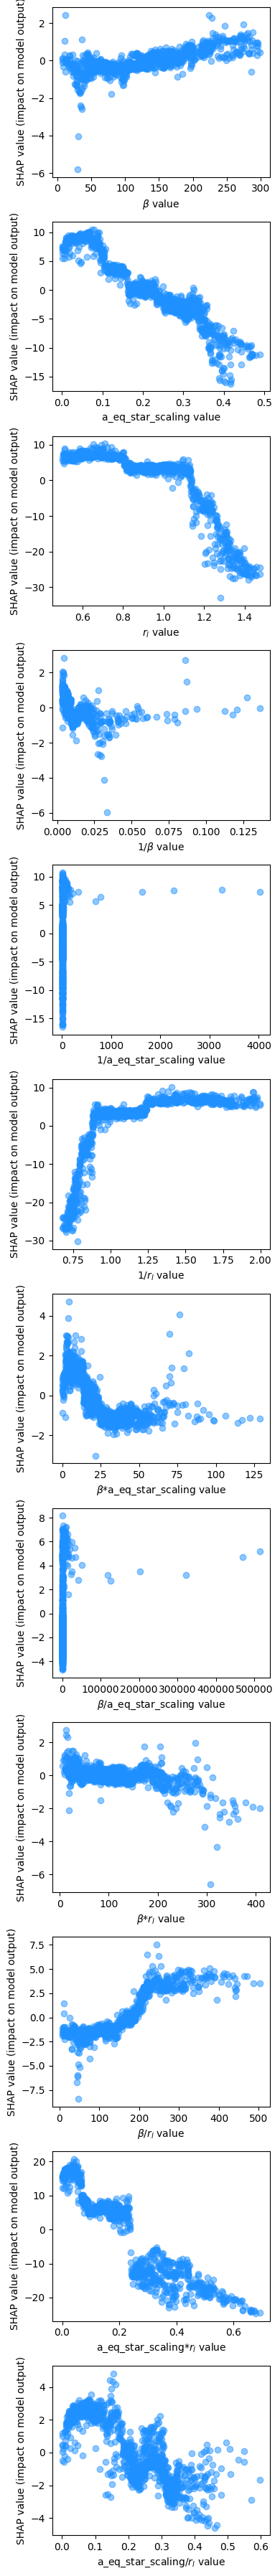

In [616]:
plot_shap_custom("final_N_bodies", X, y)

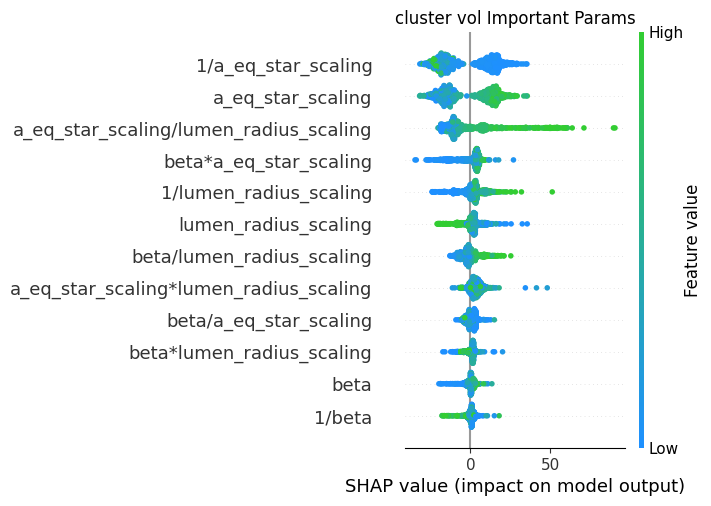

all feature names Index(['beta', 'a_eq_star_scaling', 'lumen_radius_scaling', '1/beta',
       '1/a_eq_star_scaling', '1/lumen_radius_scaling',
       'beta*a_eq_star_scaling', 'beta/a_eq_star_scaling',
       'beta*lumen_radius_scaling', 'beta/lumen_radius_scaling',
       'a_eq_star_scaling*lumen_radius_scaling',
       'a_eq_star_scaling/lumen_radius_scaling'],
      dtype='object')


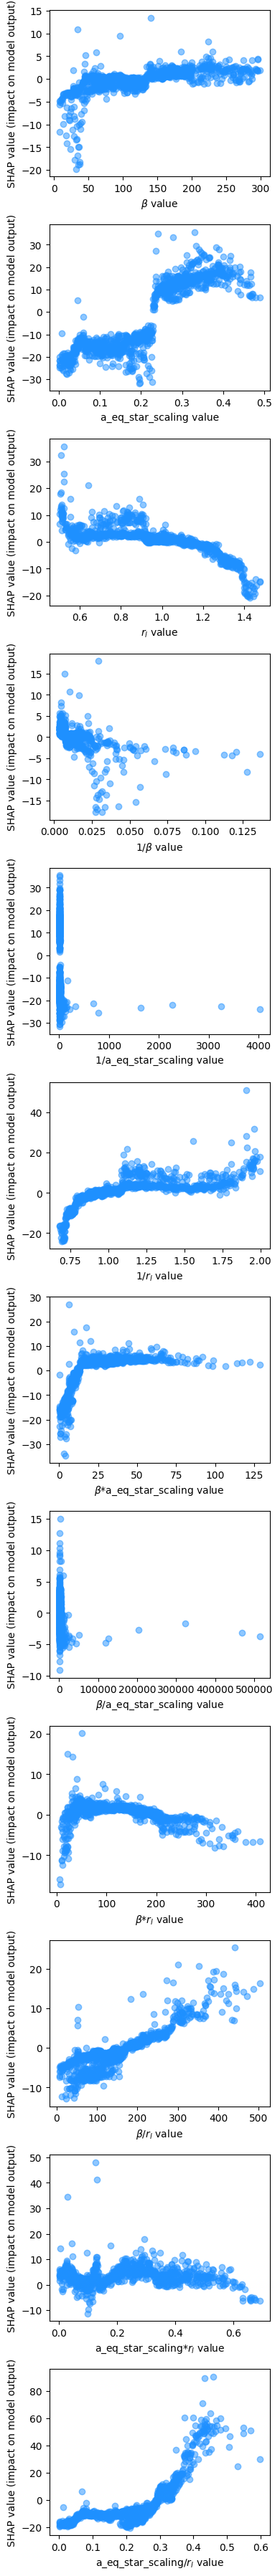

In [617]:
plot_shap_custom("cluster_vol", X, y)

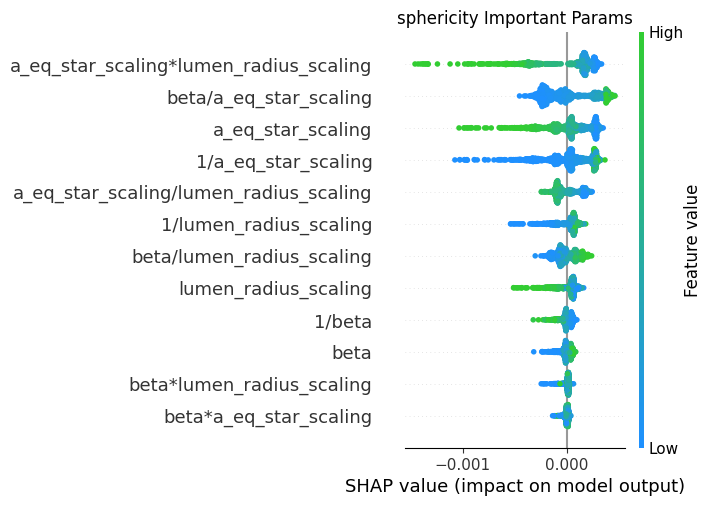

all feature names Index(['beta', 'a_eq_star_scaling', 'lumen_radius_scaling', '1/beta',
       '1/a_eq_star_scaling', '1/lumen_radius_scaling',
       'beta*a_eq_star_scaling', 'beta/a_eq_star_scaling',
       'beta*lumen_radius_scaling', 'beta/lumen_radius_scaling',
       'a_eq_star_scaling*lumen_radius_scaling',
       'a_eq_star_scaling/lumen_radius_scaling'],
      dtype='object')


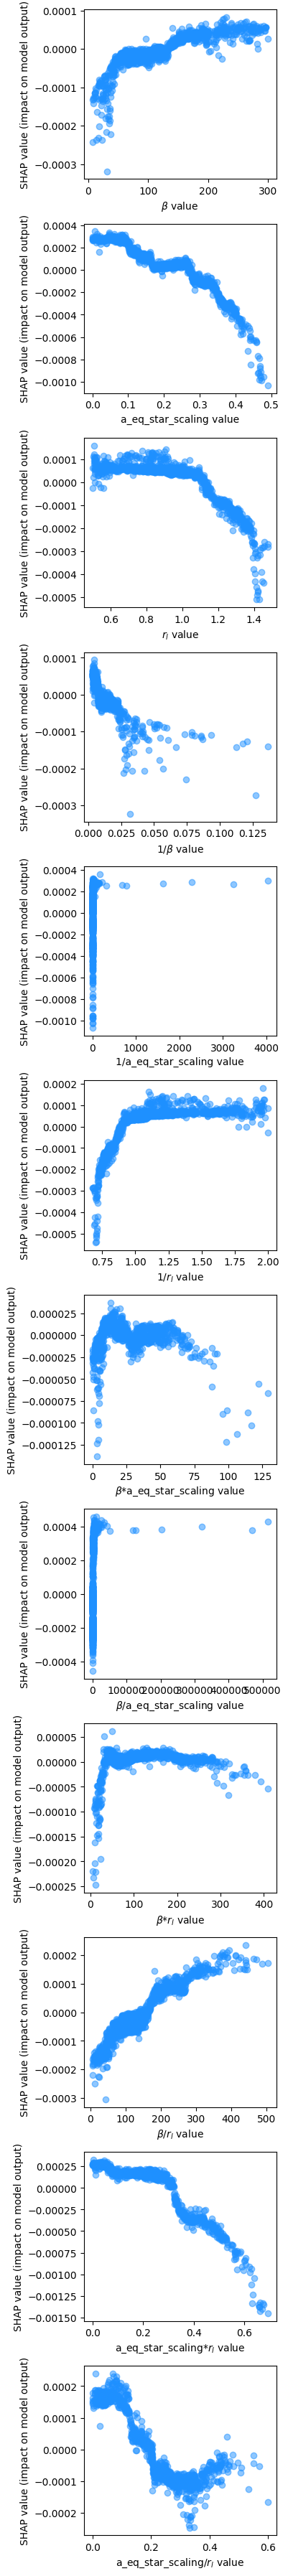

In [618]:
plot_shap_custom("sphericity", X, y)

In [554]:
for parameter in ["cluster_vol", "target", "sphericity", "final_N_bodies"]:
    model = RandomForestRegressor(max_depth=6, n_jobs=-1, n_estimators=500, max_features=0.33)
    model.fit(X, y[parameter]);
    data = pd.DataFrame(zip(X.columns, model.feature_importances_), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False).sort_values('Importance', ascending=False)[:10]
    data.to_csv("{}_feature_importance_including_combined.csv".format(parameter))

Feature  Importance
11  a_eq_star_scaling/lumen_radius_scaling    0.234165
1                        a_eq_star_scaling    0.146488
4                      1/a_eq_star_scaling    0.146145
10  a_eq_star_scaling*lumen_radius_scaling    0.074396
6                   beta*a_eq_star_scaling    0.067625
2                     lumen_radius_scaling    0.063267
5                   1/lumen_radius_scaling    0.062511
8                beta*lumen_radius_scaling    0.046668
9                beta/lumen_radius_scaling    0.043300
7                   beta/a_eq_star_scaling    0.043196

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


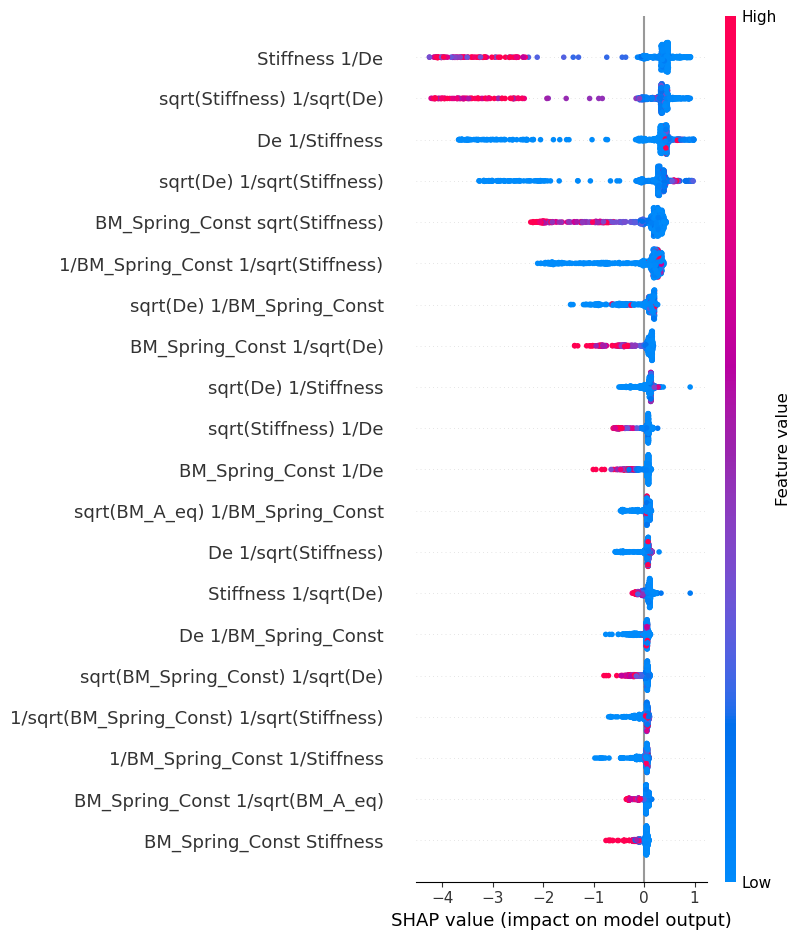

In [55]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)
# Low value of De/stiffness (blue) increases the likelihood of short finish time

In [56]:
model = RandomForestRegressor(max_depth=6, n_jobs=-1, n_estimators=500, max_features=0.33)
model.fit(X, y['Areas']);

In [57]:
pd.DataFrame(zip(X.columns, model.feature_importances_), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False).sort_values('Importance', ascending=False)[:10]

Feature  Importance
118             sqrt(BM_Spring_Const) 1/De    0.060316
89              De 1/sqrt(BM_Spring_Const)    0.051385
38              BM_Spring_Const 1/sqrt(De)    0.022787
123       sqrt(BM_Spring_Const) 1/sqrt(De)    0.020625
154             sqrt(De) 1/BM_Spring_Const    0.020444
75               Inner_Pressure 1/sqrt(De)    0.020067
84                    De 1/BM_Spring_Const    0.019412
36         BM_Spring_Const 1/sqrt(BM_A_eq)    0.018645
33                    BM_Spring_Const 1/De    0.018020
121  sqrt(BM_Spring_Const) 1/sqrt(BM_A_eq)    0.016605

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


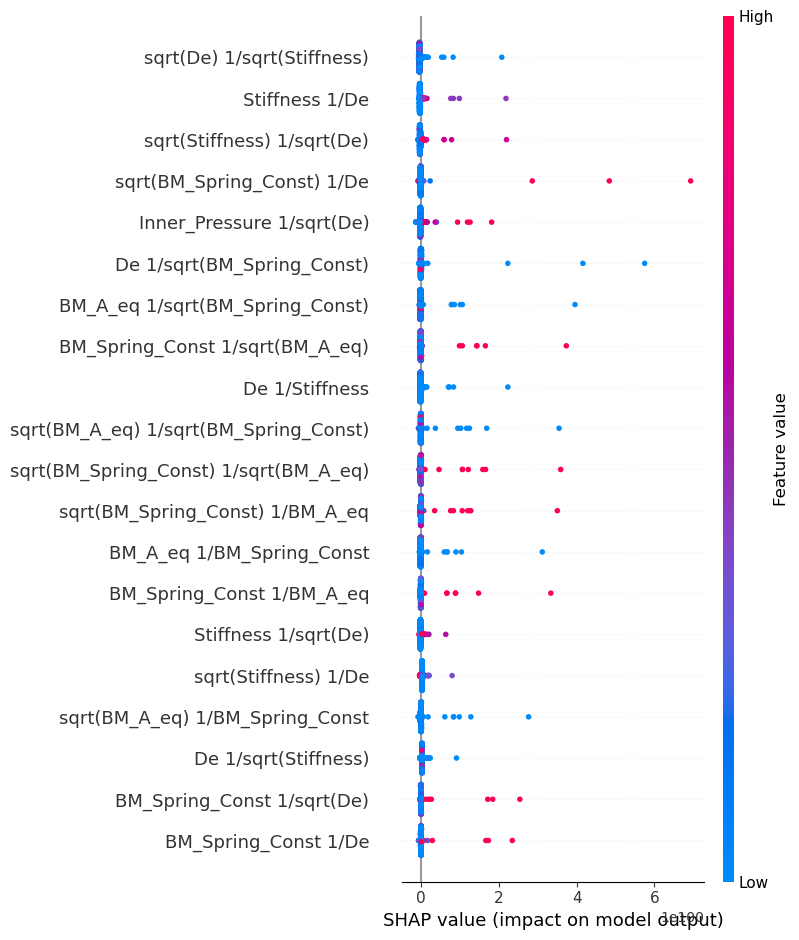

In [58]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)
# Higher values (more red) of BM spring const/BM Aeq lead to higher values (more right) of area
# Lower valeus of De/BM_spring_const = higher values of area
# Lower values of BM A_eq/BM spring_const = lower values of area


In [17]:
shap.dependence_plot("Areas", )